In [15]:
import datasets
from src.models.components.partmae_v5 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from src.models.components.metrics.partmae_v3 import V3Metrics
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
import torch.utils._pytree as pytree
from src.utils.visualization.reconstruction_v5_anchor_reparam import reconstruction_lstsq_with_anchor_reparam
from src.utils.visualization.reconstruction_v5_gt import reconstruction_gt

## Overfit Training

### Utils

In [16]:
class OverfitDataset(Dataset):
    def __init__(self, xs, transform=None):
        self.xs = xs
        self.transform = transform

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.xs[idx])
        return self.xs[idx]

In [17]:
def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Clean and organize model inputs and outputs for visualization and analysis.
    
    Args:
        batch: A tuple containing model inputs (global images, global params, local images, local params)
        out: Model output dictionary
        device: Device to move tensors to (default: "cuda")
        
    Returns:
        io: Dictionary containing organized model inputs and outputs
    """
    # Initialize output dictionary
    io = dict()
    
    # Extract shapes from model output
    g_crop_size, gN, gV = out["shapes"][0]  # global crop size, tokens per crop, number of crops
    l_crop_size, lN, lV = out["shapes"][1]  # local crop size, tokens per crop, number of crops
    
    # Extract and organize inputs
    io["x"] = [[*gxs, *lxs] for gxs, lxs in zip(batch[0], batch[2])]
    io["canonical_params"] = batch[1][:, 0, :4]
    io["params"] = [[*gp, *lp] for gp, lp in zip(batch[1], batch[3])]
    io["crop_params"] = [[param[4:8] for param in batch_params] for batch_params in io["params"]]
    io["crop_sizes"] = [*[g_crop_size for _ in range(gV)], *[l_crop_size for _ in range(lV)]]
    io["num_tokens"] = [*[gN for _ in range(gV)], *[lN for _ in range(lV)]]
    
    # Include all output values
    io.update({name: out[name] for name in out.keys()})
    
    # Move all tensors to the specified device
    io = pytree.tree_map_only(
        Tensor,
        lambda t: t.detach().to(device),
        io
    )
    
    return io


In [18]:

def make_plots(
    model,
    io,
    train_transform,
    original_img,
):
    gt_reconstruction = reconstruction_gt(
        x=io["x"][0],
        patch_positions_nopos=io["patch_positions_nopos"][0],
        num_tokens=io["num_tokens"],
        crop_params=io["crop_params"][0],
        patch_size=model.patch_size,
        canonical_img_size=model.canonical_img_size,
    )
    pred_reconstruction, *_ = reconstruction_lstsq_with_anchor_reparam(
        x=io["x"][0],
        patch_positions_nopos=io["patch_positions_nopos"][0],
        num_tokens=io["num_tokens"],
        crop_params=io["crop_params"][0],
        patch_size=model.patch_size,
        canonical_img_size=model.canonical_img_size,
        max_scale_ratio=model.max_scale_ratio,
        pred_dT=io["pred_dT"][0],
    )
    fig, axes = plt.subplots(1, 3)
    canonical_img = train_transform.recreate_canonical(
        original_img, io["canonical_params"][0]
    )
    axes[0].imshow(canonical_img)
    axes[0].set_title("Original")
    axes[1].imshow(gt_reconstruction.permute(1, 2, 0).cpu())
    axes[1].set_title("GT reconstruction")
    axes[2].imshow(pred_reconstruction.permute(1, 2, 0).cpu())
    axes[2].set_title("Reconstruction")
    return fig, axes

### Training

In [19]:
ds = datasets.load_dataset("frgfm/imagenette", "160px", split="train")

In [20]:
B = 32
imgs = ds["image"][:B]
gV = 1
lV = 5
train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
dataset = OverfitDataset(imgs, train_transform)
train_dataloader = DataLoader(dataset, batch_size=len(imgs), shuffle=False)

In [21]:
# overfit to a few batches
torch.set_float32_matmul_precision("medium")
logger = TensorBoardLogger("../../logs/tb_logs/v5/")
fabric = Fabric(precision="bf16-mixed", loggers=logger)

EPOCHS = 3000
COMPILE = False

if EPOCHS < 3000:
    COMPILE = False

with fabric.init_module():
    model = PART_mae_vit_base_patch16_dec512d8b(
        sampler="stratified_jittered",
        alpha_ts=0.8,
        mask_ratio=0.75,
        pos_mask_ratio=0.75,
        alpha_t=0.75,
        max_scale_ratio=6.0,
        canonical_img_size=512,
        alpha_s=1.0,
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    # cosine scheduler
    sched = timm.scheduler.CosineLRScheduler(
        optimizer, t_initial=EPOCHS, lr_min=1e-6, warmup_t=500, warmup_lr_init=1e-6
    )


if COMPILE:
    model = torch.compile(model, fullgraph=True, dynamic=False)
model, optimizer = fabric.setup(model, optimizer)
dataloader = fabric.setup_dataloaders(train_dataloader)
metrics = V3Metrics().to(fabric.device)

pbar = tqdm(range(EPOCHS))
global_step = 0

LOG_RECONSTRUCTION_INTERVAL = 250
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    for batch in dataloader:
        out = model(*batch)
        fabric.backward(out["loss"])
        optimizer.step()
        optimizer.zero_grad()

        metrics.update(out)
        global_step += 1

    # log

    sched.step(epoch)

    # metric_logger.on_train_epoch_end(fabric, global_step)
    metric_dict = metrics.compute()
    metric_dict["lr"] = optimizer.param_groups[0]["lr"]
    metric_dict["epoch"] = epoch

    # log reconstruction
    if epoch % LOG_RECONSTRUCTION_INTERVAL == 0:
        io = clean_model_io(batch, out)
        fig, axes = make_plots(
            model,
            io,
            train_transform,
            imgs[0],
        )
        fabric._loggers[0].experiment.add_figure(
            f"train/reconstruction",
            fig,
            global_step=global_step,
        )
        plt.close(fig)


    metric_dict = {f"train/{k}": v for k, v in metric_dict.items()}
    # log
    fabric.log_dict(metric_dict, step=global_step)
    pbar.set_description(
        f"Loss: {metric_dict['train/loss']:.4f} "
        f"Pred dt std: {metric_dict['train/pred_dt_std'] * 512:.4f}"
    )

# fabric.save(f"model_ep{EPOCHS}_gV{gV}_lV{lV}.ckpt", state=model.state_dict())

Using bfloat16 Automatic Mixed Precision (AMP)
  0%|          | 0/3000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8244047..1.3889799].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7988698..1.4440448].
Loss: 0.4082 Pred dt std: 52.1729:   8%|▊         | 250/3000 [01:58<21:44,  2.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7859048..2.3717844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5223472..2.3377242].
Loss: 0.3890 Pred dt std: 60.2555:  17%|█▋        | 500/3000 [03:57<19:48,  2.10it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7869284..2.1771355].
Clipping input dat

In [22]:
# EPOCHS=5000
# state_dict = fabric.load(f"model_ep{EPOCHS}_gV{gV}_lV{lV}.ckpt")
# model.load_state_dict(state_dict)

## Reconstruction

### Utils

### Least squares with anchor (reparametrized)

In [23]:
def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Clean and organize model inputs and outputs for visualization and analysis.
    
    Args:
        batch: A tuple containing model inputs (global images, global params, local images, local params)
        out: Model output dictionary
        device: Device to move tensors to (default: "cuda")
        
    Returns:
        io: Dictionary containing organized model inputs and outputs
    """
    # Initialize output dictionary
    io = dict()
    
    # Extract shapes from model output
    g_crop_size, gN, gV = out["shapes"][0]  # global crop size, tokens per crop, number of crops
    l_crop_size, lN, lV = out["shapes"][1]  # local crop size, tokens per crop, number of crops
    
    # Extract and organize inputs
    io["x"] = [[*gxs, *lxs] for gxs, lxs in zip(batch[0], batch[2])]
    io["canonical_params"] = batch[1][:, 0, :4]
    io["params"] = [[*gp, *lp] for gp, lp in zip(batch[1], batch[3])]
    io["crop_params"] = [[param[4:8] for param in batch_params] for batch_params in io["params"]]
    io["crop_sizes"] = [*[g_crop_size for _ in range(gV)], *[l_crop_size for _ in range(lV)]]
    io["num_tokens"] = [*[gN for _ in range(gV)], *[lN for _ in range(lV)]]
    
    # Include all output values
    io.update({name: out[name] for name in out.keys()})
    
    # Move all tensors to the specified device
    io = pytree.tree_map_only(
        Tensor,
        lambda t: t.detach().to(device),
        io
    )
    
    return io


In [24]:
io = clean_model_io(batch, out, 'cpu')

In [25]:
batch = next(iter(dataloader))
with torch.no_grad():
    g_x, g_params, l_x, l_params = batch
    out = model(g_x, g_params, l_x, l_params)

io = clean_model_io(batch, out, 'cuda')


In [26]:
io["num_tokens"]

[37, 7, 7, 7, 7, 7]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8360041..2.2296228].


torch.Size([3, 512, 512])


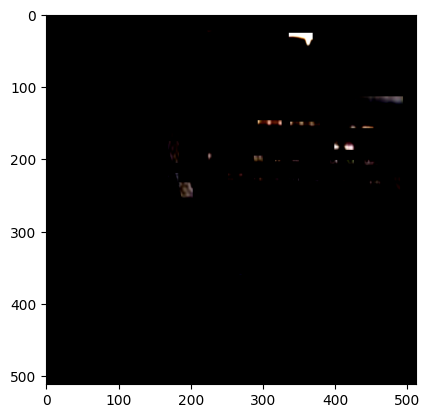

In [27]:
from src.utils.visualization.lstsq_solver import lstsq_dT_solver as lstsq_solver
from src.utils.visualization.reconstruction_v5_gt import reconstruction_gt

reconstructed_img_gt = reconstruction_gt(
    x = io["x"][0],
    patch_positions_nopos=io["patch_positions_nopos"][0],
    num_tokens=io["num_tokens"],
    crop_params=io["crop_params"][0],
    patch_size=model.patch_size,
    canonical_img_size=model.canonical_img_size,
)

print(reconstructed_img_gt.shape)
plt.imshow(reconstructed_img_gt.permute(1, 2, 0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8360041..2.2296228].


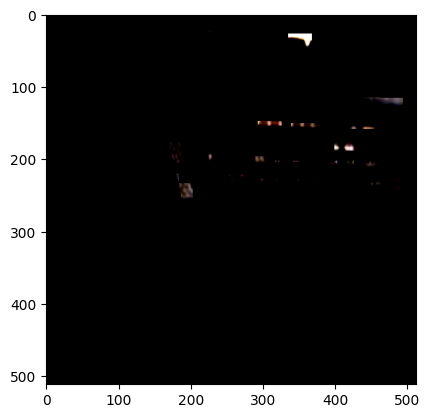

In [28]:
from src.utils.visualization.lstsq_solver import lstsq_dT_solver as lstsq_solver
from src.utils.visualization.reconstruction_v5_anchor_reparam import reconstruction_lstsq_with_anchor_reparam

reconstructed_img_gt, *_ = reconstruction_lstsq_with_anchor_reparam(
    x = io["x"][0],
    patch_positions_nopos=io["patch_positions_nopos"][0],
    num_tokens=io["num_tokens"],
    crop_params=io["crop_params"][0],
    patch_size=model.patch_size,
    canonical_img_size=model.canonical_img_size,
    max_scale_ratio=model.max_scale_ratio,
    pred_dT=io["gt_dT"][0],
)

plt.imshow(reconstructed_img_gt.permute(1, 2, 0).cpu())